In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from libsx import *
import pickle

In [2]:
Msun = M_sun = 1.98992e+33 # gram
Mcld = 1.0 * Msun

G = 6.6738e-8

rho_0 = 1.7e-17 # g/cm^3
r_0 = 2.9e16 # cm
R = 5e16 # cm ; cloud radius
omega = 1e-12 # s^-1

In [3]:
# Calculating derived quantities
tff = np.sqrt(3*np.pi/(32*G*rho_0))                   # The free-fall time = 3.4e4 yr

In [4]:
# Setting the units of the simulation
unitMass_in_g = M_sun                                                 # 1 solar mass
unitTime_in_s = tff                                                  # Scaling time to free-fall time
unitLength_in_cm = R                                               # Scaling distance to the initial cloud radius
unitVelocity_in_cm_per_s = unitLength_in_cm / unitTime_in_s          # The internal velocity unit

In [5]:
print('unitVelocity_in_cm_per_s = ', unitVelocity_in_cm_per_s)

unitVelocity_in_cm_per_s =  98134.22211512487


In [6]:
print(f'Unit_time_in_s = {round(unitTime_in_s, 2)} seconds')
print(f'Unit_time in kyrs = {round(unitTime_in_s/3600./24./365.25/1000., 2)} kyrs')
print(f'Unit_time in Myrs = {round(unitTime_in_s/3600./24./365.25/1e6, 4)} Myrs')

Unit_time_in_s = 509506255028.37 seconds
Unit_time in kyrs = 16.15 kyrs
Unit_time in Myrs = 0.0161 Myrs


In [7]:
rgrid = np.logspace(14, np.log10(R), 1000)

In [8]:
res = []

for r in rgrid:

    coeff1 = 4.*np.pi*rho_0/Mcld
    coeff2 = -0.5 * r / r_0 * np.exp(-(r/r_0)**2)
    coeff3 = np.sqrt(np.pi) / 4.0 * math.erf(r/r_0)
    
    ksi = r_0**3 * coeff1 * (coeff2 + coeff3)
    
    res.append([r, ksi])

res = np.array(res)
r = res[:, 0]
ksi = res[:, 1]

ksi[ksi > 1.] = 1.0 #!!!!!!!!!!!!!!!!!!!

## Create normalize ksi1, ksi2, and ksi3

In [9]:

Npart = 30000

resx = []

for i in range(Npart):

    ksi_1 = np.random.random()
    ksi_2 = np.random.random()
    ksi_3 = np.random.random()

    #if (ksi_1**2 + ksi_2**2) < 1.0:
    #    ksi_3 = np.sqrt(1.0 - (ksi_1**2 + ksi_2**2))
    resx.append([ksi_1, ksi_2, ksi_3])

resx = np.array(resx)

In [10]:
np.sum(resx**2, axis=1)

array([1.47273301, 1.49304174, 1.03836136, ..., 0.94955036, 0.49154439,
       0.75908899])

In [11]:
pos = []

for j in range(resx.shape[0]):
    
    ksi1 = resx[j, 0]
    ksi2 = resx[j, 1]
    ksi3 = resx[j, 2]
    
    # Finding r
    nt = np.where((ksi - ksi1) >= 0.0)[0][0]
    rr = r[nt]
    
    # Finding theta
    theta = np.arccos(1.0 - 2.*ksi2)
    
    # Finding phi
    phi = 2.0 * np.pi * ksi3
    
    # Converting to Cartesian coordinate
    x = rr * np.sin(theta) * np.cos(phi)
    y = rr * np.sin(theta) * np.sin(phi)
    z = rr * np.cos(theta)
    
    pos.append([x, y, z])

pos = np.array(pos)
print(pos.shape)

(30000, 3)


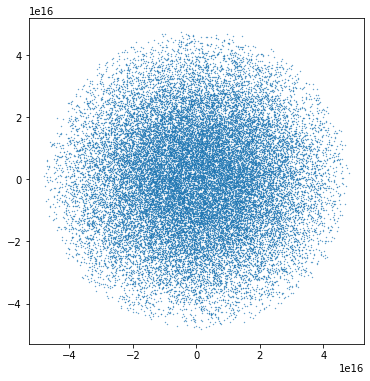

In [12]:
plt.figure(figsize = (6,6))
plt.scatter(pos[:, 0], pos[:, 1], s = 0.1);

# calling things to code units

In [13]:
# calling things to code units
pos /= unitLength_in_cm
Mcld /= unitMass_in_g
omega *= unitTime_in_s

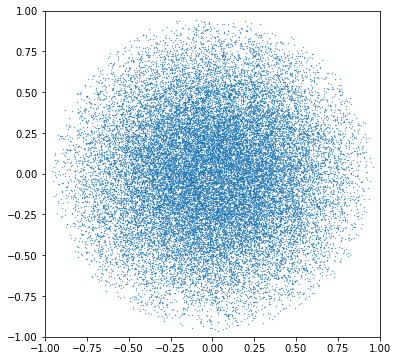

In [23]:
plt.figure(figsize = (6,6))
plt.scatter(pos[:, 0], pos[:, 1], s = 0.1)
plt.xlim(-1, 1)
plt.ylim(-1, 1);

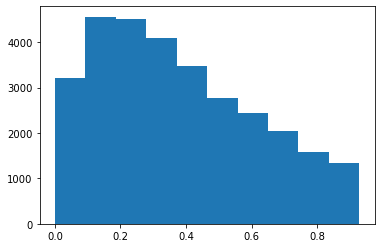

In [26]:
plt.hist(np.sum(pos**2, axis = 1));

In [15]:
TA = time.time()
h = do_smoothingX((pos, pos))
print('Elapsed time = ', time.time() - TA)

Elapsed time =  144.71755504608154


In [16]:
masses = Mcld / pos.shape[0] * np.ones(pos.shape[0])

In [17]:
#-------- rho ---------
rho = getDensity(pos, masses, h)

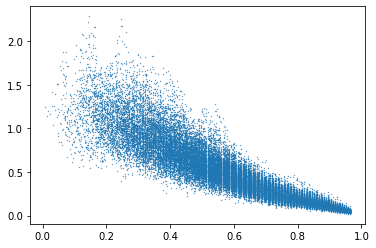

In [18]:
rr = (pos[:, 0]*pos[:, 0] + pos[:, 1]*pos[:, 1] + pos[:, 2]*pos[:, 2])**0.5
plt.scatter(rr, (rho), s = 0.1); #!!!! NOte the division by 0.25 for normalization !!

/home/pc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


min(rho) = 0.04960348234636809
max(rho) = 1.3874918016884799
max(rho)/min(rho) = 27.971661182978828


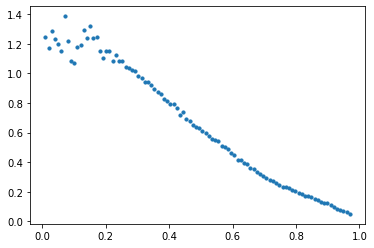

In [19]:
grid = np.linspace(0, 1, 100)

res = []

for i in range(len(grid)-1):
    
    rbeg = grid[i]
    rend = grid[i+1]
    
    nx = np.where((rr >= rbeg) & (rr < rend))[0]
    
    res.append([rend, np.mean(rho[nx])])

res = np.array(res)

print(f'min(rho) = {min(res[:, 1])}')
print(f'max(rho) = {max(res[:, 1])}')
print(f'max(rho)/min(rho) = {max(res[:, 1])/min(res[:, 1])}')

plt.scatter(res[:, 0], res[:, 1], s = 10);

# Particles velocity

In [20]:
rxy = (pos[:,0]**2 + pos[:,1]**2)**0.5 
vel = np.zeros_like(pos)

vel[:,0] = -omega*pos[:,1]
vel[:,1] = omega*pos[:,0]

vel[:,2] = 0

wh = np.argwhere(np.isnan(vel)) # NaNs are handled here !
if len(wh) > 0:
    vel[wh] = 0.0

In [21]:
omega

0.5095062550283749

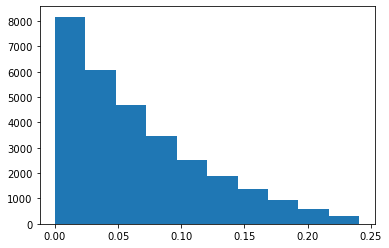

In [22]:
plt.hist(np.sum(vel**2, axis = 1));

# Adding the perturbation to the mass

In [21]:
rxy = (pos[:,0]**2 + pos[:,1]**2)**0.5
mp = Mcld / pos.shape[0]

# Imposing an m=2 density perturbation with an amplitude of 10 percent.
masses = mp * (1 + .1*((pos[:, 0]/rxy)**2 - (pos[:, 1]/rxy)**2))

wh = np.argwhere(np.isnan(masses)) # Fixes an issue with the particle at the origin
if len(wh) > 0:
    masses[wh] = mp

In [22]:
vel

array([[ 0.24838722,  0.02008202,  0.        ],
       [ 0.16368042, -0.03841602,  0.        ],
       [-0.13120975,  0.12925781,  0.        ],
       ...,
       [-0.04137701,  0.20315008,  0.        ],
       [-0.12440768, -0.12248434,  0.        ],
       [-0.07536399, -0.03342933,  0.        ]])

In [23]:
dictx = {'r': pos, 'v': vel, 'm': masses,
         'unitVelocity': unitVelocity_in_cm_per_s,
         'unitTime': unitTime_in_s}

num = str(int(np.floor(pos.shape[0]/1000)))

with open('Gauss_' + num +'k_tmp.pkl', 'wb') as f:
    pickle.dump(dictx, f)